In [10]:
# imports
import azureml.core

In [11]:
# assign current workspace
from azureml.core import Workspace
ws = Workspace.from_config()
print('Current workspace:', ws.name)

Current workspace: ml-workspace


In [12]:
# assign datastore
ds = ws.get_default_datastore()
print('Current datastore:', ds.name)

Current datastore: workspaceblobstore


In [20]:
# upload the file to blob
ds.upload_files(files=['./data/heart.csv'], target_path='data-heart/', overwrite=True, show_progress=True)

Uploading an estimated of 1 files
Uploading ./data/heart.csv
Uploaded ./data/heart.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_39dde4d9e65f4c928ee8a8ff32f49928

In [21]:
# register the dataset
from azureml.core import Dataset

# name of our dataset
ds_name = 'heart dataset'

if 'heart dataset' not in ws.datasets:
    # create tabular dataset from the data
    heart_data = Dataset.Tabular.from_delimited_files(path=(ds, 'data-heart/*.csv'))

    # register the dataset
    try:
        heart_data = heart_data.register(workspace=ws,
                                         name = ds_name,
                                         description= 'Heart Attach Data',
                                         tags = {'format' : 'csv'},
                                         create_new_version = True)
        print('Dataset %s registered with version %i.'%(heart_data.name, str(heart_data.version)))
    except Exception as ex:
        print(ex)
else:
    print('Dataset already registered.')


Dataset already registered.


In [23]:
# Create a local folder for the pipeline step files

import os
experiment_folder = './heart_pipeline'
os.makedirs(experiment_folder, exist_ok=True)
print(experiment_folder)

./heart_pipeline


## Pipeline Step 1: Prep data

In [71]:
%%writefile $experiment_folder/prep_heart.py
# Import libraries
import os
import argparse
import pandas as pd
from azureml.core import Run
from sklearn.preprocessing import MinMaxScaler

# Get parameters
parser = argparse.ArgumentParser()
parser.add_argument('--input-data', type=str, dest='raw_dataset_id',
                    help='raw dataset')
parser.add_argument('--prepped-data', type=str, dest='prepped_data',
                    default='prepped_data',
                    help='Folder for results')
args = parser.parse_args()
save_folder = args.prepped_data

# Get experiment run context
run = Run.get_context()

# Load data
print('Loading Data...')
heart_df = run.input_datasets['raw_data'].to_pandas_dataframe()

# Log raw dataset details
run.log('Raw rows:', heart_df.shape[0])
run.log('Raw columns:', heart_df.shape[1])

# Drop NAs
heart_df = heart_df.dropna()

# Modifying prediction label
heart_df.rename(columns={'output' : 'heart_attack'}, inplace=True)

# Change sex categorical feature to dummies
sex_type = pd.get_dummies(data=heart_df['sex'])
sex_type.columns = ['Male', 'Female']
chest_pain = pd.get_dummies(data=heart_df['cp'])
chest_pain.columns = ['Chest Pain 1', 'Chest Pain 2', 'Chest Pain 3',
                      'Chest Pain 4']
ex_angina = pd.get_dummies(data=heart_df['exng'])
ex_angina.columns = ['Exercise Angina: No', 'Exercise Angina: Yes']
slp_type = pd.get_dummies(data=heart_df['slp'])
slp_type.columns = ['Slope 1', 'Slope 2', 'Slope 3']
caa_type = pd.get_dummies(data=heart_df['caa'])
caa_type.columns = ['CAA 1', 'CAA 2', 'CAA 3', 'CAA 4', 'CAA 5']
thall_type = pd.get_dummies(data=heart_df['thall'])
thall_type.columns = ['Thall 1', 'Thall 2', 'Thall 3', 'Thall 4']


# Joining and removing modified columns
heart_df = pd.concat([sex_type, chest_pain, ex_angina, slp_type,
                      caa_type, thall_type, heart_df],
                     axis=1)
heart_df.drop(labels=['sex', 'cp', 'exng', 'slp', 'caa', 'thall'], 
              axis=1, inplace=True)

# Normalize numeric columns
scaler = MinMaxScaler()
norm_cols = ['age', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
                'oldpeak']
heart_df[norm_cols] = scaler.fit_transform(heart_df[norm_cols])

# Save the prepped data
print('Saving Data...')
os.makedirs(save_folder, exist_ok=True)
save_path = os.path.join(save_folder, 'heartdata_norm.csv')
heart_df.to_csv(save_path, index=False, header=True)


Loading Data...
Saving Data...


## Pipeline Step 2: Train model

Loading Data...
Training model...
Accuracy: 0.7362637362637363
AUC: 0.7359767891682786


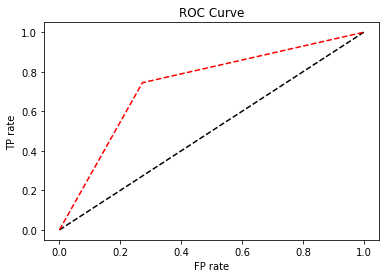

Saving model...


['./outputs/heart_model.pkl']

In [88]:
from azureml.core import Run, Model
import argparse
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Get parameters


# Get the experiment run context

# Load the data
print('Loading Data...')
heart = pd.read_csv(save_path)

# Separate features from labels
X, y = heart.iloc[:,0:-1].values, heart.iloc[:,-1]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                    random_state=0)

# Train model
print('Training model...')
model = DecisionTreeClassifier().fit(X_train, y_train)

# Calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)

# Calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC:', auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
fig = plt.figure(figsize=(6,4))
plt.plot([0,1], [0,1], 'k--') # diagonal 50% line
plt.plot(fpr, tpr, 'r--')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC Curve')
plt.show()

# Save trained model 
print('Saving model...')
os.makedirs('./outputs', exist_ok=True)
model_file = os.path.join('./outputs', 'heart_model.pkl')
joblib.dump(value=model, filename=model_file)

# Register model
print('Registering model...')
Model.register(workspace=ws,)


In [77]:
X

array([[0.        , 1.        , 0.        , ..., 0.        , 0.60305344,
        0.37096774],
       [0.        , 1.        , 0.        , ..., 0.5       , 0.88549618,
        0.56451613],
       [1.        , 0.        , 0.        , ..., 0.        , 0.77099237,
        0.22580645],
       ...,
       [0.        , 1.        , 1.        , ..., 0.5       , 0.53435115,
        0.5483871 ],
       [0.        , 1.        , 1.        , ..., 0.5       , 0.33587786,
        0.19354839],
       [1.        , 0.        , 0.        , ..., 0.        , 0.78625954,
        0.        ]])

Loading Data...
